# Описание

Решение задачи классификации наличия болезни сердца у пациентов. Данные для обучения моделей [здесь](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. (Подробнее о признаках можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.)

## Этап 1. Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42

In [2]:
# Загрузка данных
data = pd.read_csv("../data/heart/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Этап 2. Подготовка датасета

### Преобразование категориальных переменных

Здесь мы используем `LabelEncoder` для преобразования категориальных переменных в числовые.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

encoded_data = data.copy()
# Применяем LabelEncoder ко всем столбцам, которые нужно закодировать
for column in encoded_data.columns:
    # Применяем LabelEncoder только к столбцам с категориальными данными
    if encoded_data[column].dtype == "object":
        encoded_data[column] = label_encoder.fit_transform(encoded_data[column])

# Выводим результат
encoded_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


### Визуализация

Создаем графики для визуализации, используя plotly. Например, посмотрим на распределение заболеваний сердца по полу и возрасту.

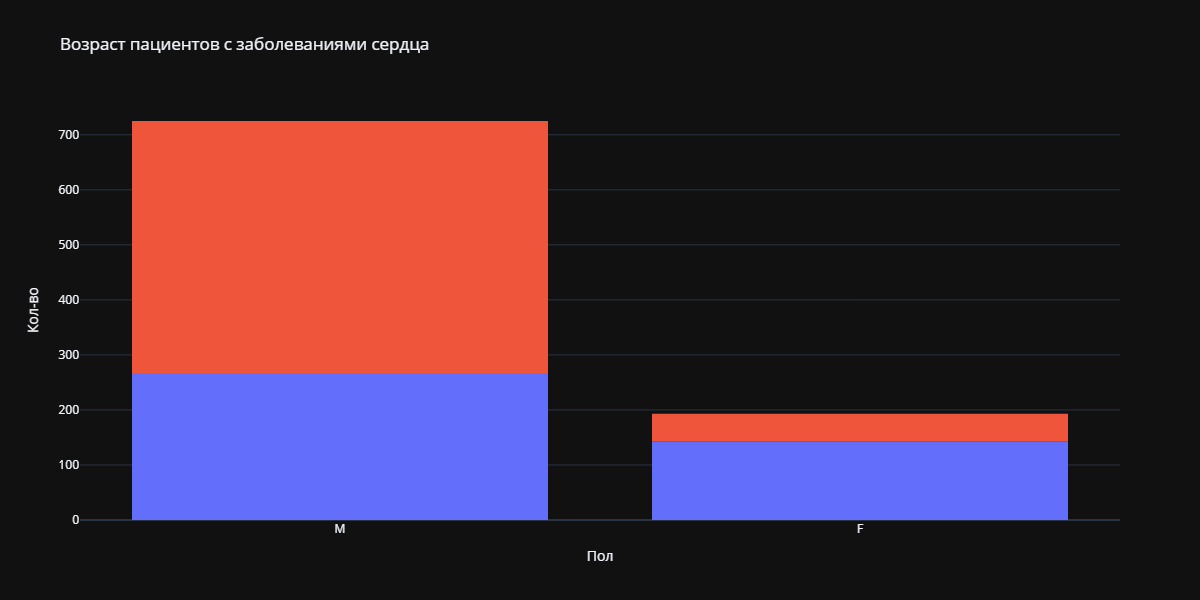

In [5]:
import plotly.express as px

# Визуализация: Распределение заболеваний сердца по полу
fig = px.histogram(
    data,
    x="Sex",
    color="HeartDisease",
    title="Распределение заболеваний сердца по полу",
)
fig.update_layout(
    title="Возраст пациентов с заболеваниями сердца",
    xaxis_title="Пол",
    yaxis_title="Кол-во",
    showlegend=False,
    template="plotly_dark",
    height=600,
    width=1200,
)
fig.show("png")

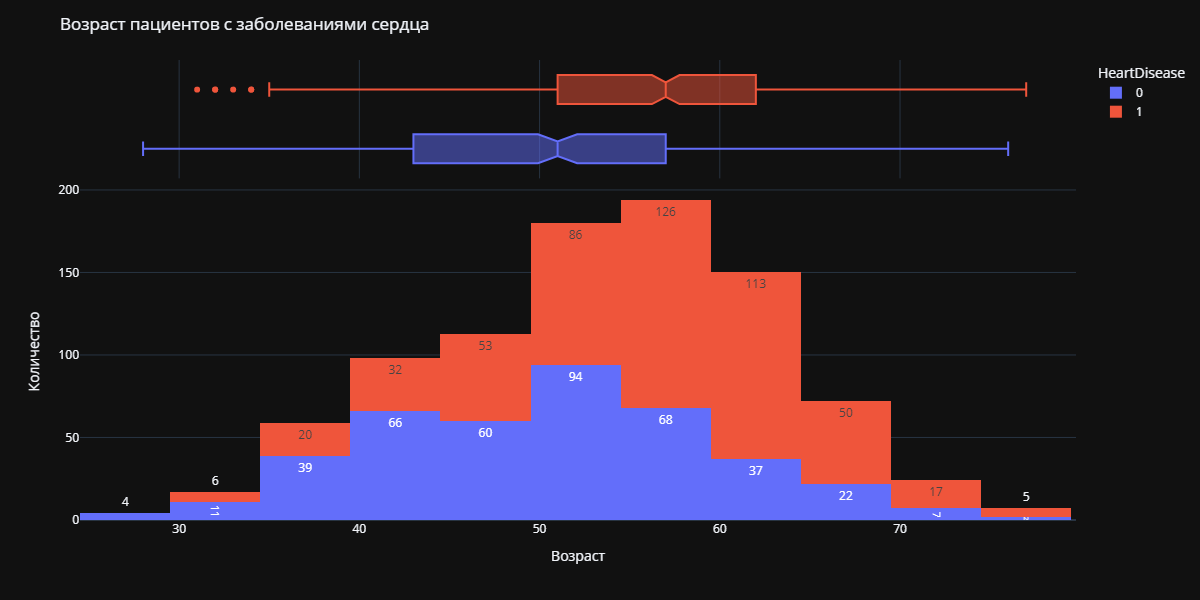

In [6]:
# Создание гистограммы с боксплотом
fig = px.histogram(
    data,
    x="Age",  # Прямое указание на х-ось
    marginal="box",  # Добавление боксплота
    nbins=len(
        np.histogram_bin_edges(data["Age"], bins="fd")
    ),  # Автоматический выбор количества бинов
    color="HeartDisease",  # Цвет по наличию заболеваний сердца
    text_auto=True,  # Включение автоматических текстовых меток
    width=800,
)

# Настройка параметров макета графика
fig.update_layout(
    title="Возраст пациентов с заболеваниями сердца",  # Заголовок графика
    xaxis_title="Возраст",  # Подпись оси X
    yaxis_title="Количество",  # Подпись оси Y
    showlegend=True,  # Показывать легенду
    template="plotly_dark",  # Темный шаблон
    height=600,  # Высота графика
    width=1200,  # Ширина графика
)

# Отображение графика
fig.show("png")

## Этап 3. Разделение выборки на тренировочную и тестовую

In [7]:
X = encoded_data.drop("HeartDisease", axis=1)
y = encoded_data["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

## Этап 4. Обучение "деревянных" моделей

### Дерево решений

In [8]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Случайный лес

In [9]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Этап 5. Метрики обученных моделей

In [10]:
# Дерево решений
y_pred_dt = dt_model.predict(X_test)
print("Метрики для дерева решений:\n", classification_report(y_test, y_pred_dt))

# Случайный лес
y_pred_rf = rf_model.predict(X_test)
print("Метрики для случайного леса:\n", classification_report(y_test, y_pred_rf))

Метрики для дерева решений:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        77
           1       0.86      0.75      0.80       107

    accuracy                           0.78       184
   macro avg       0.78      0.79      0.78       184
weighted avg       0.79      0.78      0.78       184

Метрики для случайного леса:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        77
           1       0.90      0.90      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## Этап 6. Визуализация важности признаков модели случайного леса

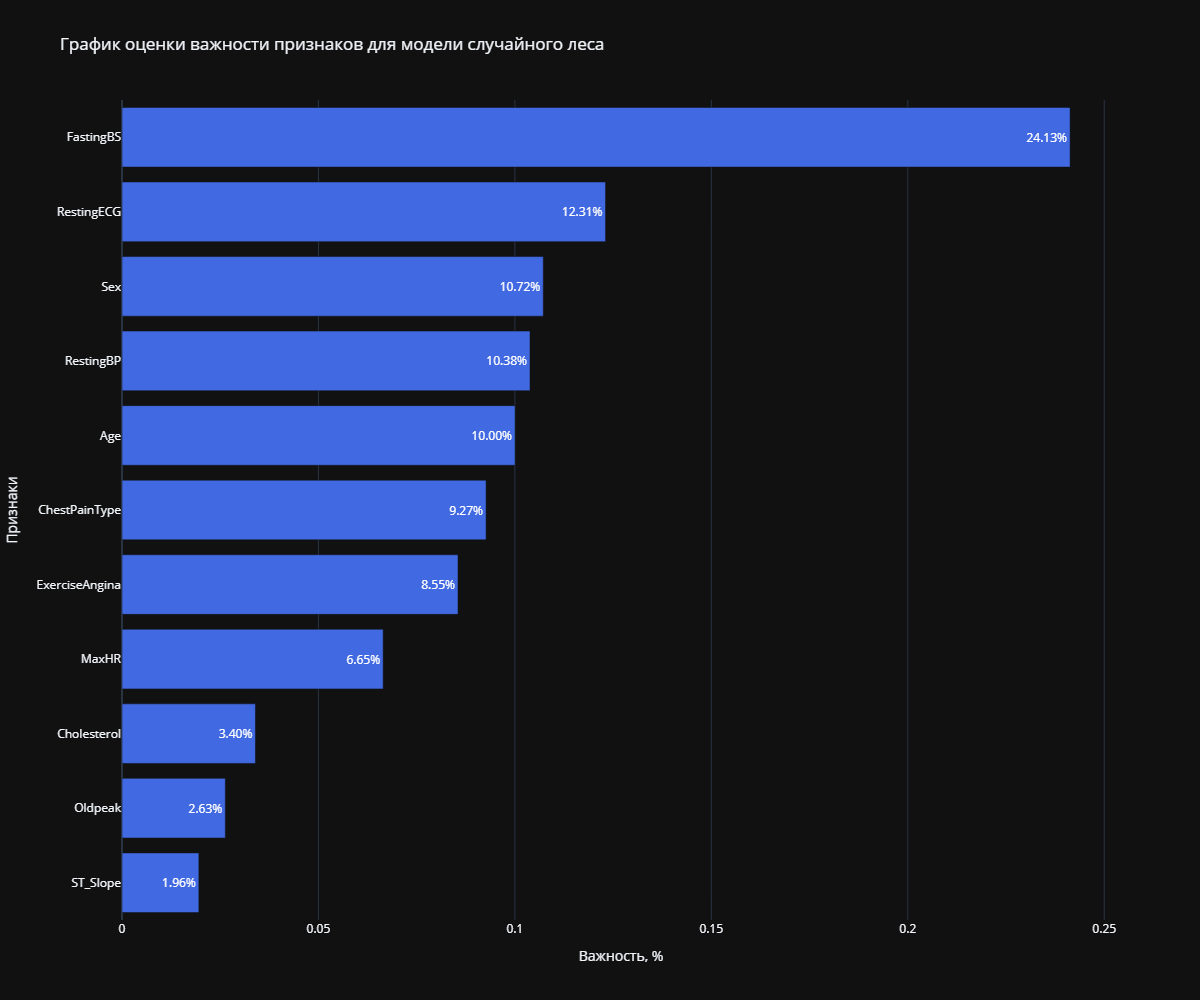

In [11]:
# Получаем важность признаков и индексы
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Создаем список названий признаков и их важности для графика
features = X.columns[indices]
importances_sorted = importances[indices][::-1]

# Преобразуем важность в проценты и форматируем с 2 знаками после запятой
percent_importances = [f"{importance * 100:.2f}%" for importance in importances_sorted]

# Создаем график
fig = go.Figure()

# Добавляем столбцы с важностью признаков
fig.add_trace(
    go.Bar(
        x=importances_sorted,
        y=features,
        orientation="h",  # горизонтальная ориентация
        marker=dict(color="royalblue"),
        text=percent_importances,  # Подписи, показывающие важность в процентах
        textposition="auto",  # Автоматическое позиционирование текста
    )
)

# Задаем заголовок и метки осей
fig.update_layout(
    title="График оценки важности признаков для модели случайного леса",
    xaxis_title="Важность, %",
    yaxis_title="Признаки",
    showlegend=False,
    template="plotly_dark",
    height=1000,
    width=1200,
)

# Отображаем график
fig.show("png")

## Этап 7. Обучение бэггинга над моделью случайного леса

In [12]:
bagging = BaggingClassifier(dt_model, random_state=RANDOM_STATE)
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  random_state=42)

### Метрики для бэггинга

In [13]:
y_pred_bg = bagging.predict(X_test)
print("Метрики для бэггинга:\n", classification_report(y_test, y_pred_bg))

Метрики для бэггинга:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85        77
           1       0.93      0.84      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.87      0.87       184



## Этап 8. Обучение стэкинга трех моделей

In [14]:
# Стек модели
estimators = [
    ("dt", dt_model),
    ("rf", rf_model),
    ("svc", LinearSVC(random_state=RANDOM_STATE)),
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LinearSVC())
stacking_model.fit(X_train, y_train)

# Предсказание для стекинга
y_pred_stacking = stacking_model.predict(X_test)
print("Метрики для стекинга:\n", classification_report(y_test, y_pred_stacking))

Метрики для стекинга:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



# Вывод

`Дерево решений`
- **Precision** для класса 0: 0.70, для класса 1: 0.86
- **Recall** для класса 0: 0.83, для класса 1: 0.75
- **F1-score** для класса 0: 0.76, для класса 1: 0.80
- **Accuracy**: 0.78

`Случайный лес`
- **Precision** для класса 0: 0.86, для класса 1: 0.90
- **Recall** для класса 0: 0.86, для класса 1: 0.90
- **F1-score** для класса 0: 0.86, для класса 1: 0.90
- **Accuracy**: 0.88

`Бэггинг`
- **Precision** для класса 0: 0.80, для класса 1: 0.93
- **Recall** для класса 0: 0.91, для класса 1: 0.84
- **F1-score** для класса 0: 0.85, для класса 1: 0.88
- **Accuracy**: 0.87

`Стекинг`
- **Precision** для класса 0: 0.84, для класса 1: 0.90
- **Recall** для класса 0: 0.87, для класса 1: 0.88
- **F1-score** для класса 0: 0.85, для класса 1: 0.89
- **Accuracy**: 0.88

`Вывод о лучшей модели`

Сравнение метрик показывает, что наилучшие результаты демонстрирует модель случайного леса:

- **Accuracy** составляет 0.88, что выше, чем у остальных моделей.
- Метрики **precision**, **recall** и **f1-score** для обоих классов (0 и 1) также находятся на высоком уровне (0.86 и 0.90 соответственно), что указывает на хорошую способность модели не только распознавать положительные случаи, но и избегать ложных срабатываний.

Второе место по показателям занимает бэггинг и стекинг (с одинаковыми значениями accuracy 0.88), однако, у бэггинга наблюдается более яркое различие между метриками для разных классов. Хотя **precision** для класса 1 выше, **recall** для класса 0 значительно ниже при сравнении со случайным лесом. Это может указывать на то, что бэггинг может недооценивать часть класса 0, что менее предпочтительно в ситуациях, где важно не пропустить положительные случаи.

Таким образом, наилучшей моделью в рамках данной задачи представляется случайный лес, так как он обеспечивает сбалансированное соотношение между **precision** и **recall**.